In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
from importlib import reload
import os
import matplotlib.pyplot as plt

In [3]:
!export CUDA_VISIBLE_DEVICES=""

In [4]:
from magenta.models.rl_tuner import rl_tuner
from magenta.models.rl_tuner import rl_tuner_ops
from magenta.contrib import training as contrib_training

/home/vinkovskiy/.local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/vinkovskiy/.local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [5]:
# Keep default RNN params for all experiments
hparams = rl_tuner_ops.default_hparams()

## Helpers

In [6]:
def plot_rewards(rl_net):
  reward_batch = rl_net.output_every_nth
  x = np.array([reward_batch * i for i in np.arange(len(rl_net.eval_avg_reward))])
  start_index = 0 # / self.output_every_nth
  plt.figure()
  plt.plot(x, rl_net.eval_avg_reward)
  plt.plot(x, rl_net.eval_avg_music_theory_reward)
  plt.plot(x, rl_net.eval_avg_note_rnn_reward)
  plt.xlabel('Training epoch')
  plt.ylabel('Average reward')
  plt.legend(['Total', 'Music theory', 'Note RNN'], loc='best')
  plt.show()

## Train network

## Q Algorithm

In [37]:
output_dir = "/tmp/rl_tuner/"
note_rnn_checkpoint_dir = '/home/vinkovskiy/magenta/magenta/note_rnn_checkpoints'
note_rnn_checkpoint_name = 'note_rnn.ckpt'
note_rnn_type = 'default'
training_steps = 1500000
exploration_steps = 500000
exploration_mode = 'boltzmann'
output_every_nth = 50000
num_notes_in_melody = 32
reward_scaler = 1
midi_primer = '/home/vinkovskiy/magenta/magenta/magenta/testdata/primer.mid'
algorithm = 'q'
output_ckpt = algorithm + ".ckpt"
backup_checkpoint_file = os.path.join(note_rnn_checkpoint_dir, note_rnn_checkpoint_name)

In [41]:
dqn_hparams = contrib_training.HParams(
      random_action_probability=0.15,
      store_every_nth=1,
      train_every_nth=5,
      minibatch_size=32,
      discount_rate=0.5,
      max_experience=100000,
      target_network_update_rate=0.01)

In [42]:
reload(rl_tuner_ops)
reload(rl_tuner)
rl_tuner.reload_files()

In [43]:
rl_net = rl_tuner.RLTuner(output_dir=output_dir,
                          midi_primer=midi_primer,
                          dqn_hparams=dqn_hparams,
                          reward_scaler=reward_scaler,
                          save_name=output_ckpt,
                          output_every_nth=output_every_nth,
                          note_rnn_checkpoint_dir=note_rnn_checkpoint_dir,
                          note_rnn_checkpoint_file=backup_checkpoint_file,
                          note_rnn_type=note_rnn_type,
                          note_rnn_hparams=hparams,
                          num_notes_in_melody=num_notes_in_melody,
                          exploration_mode=exploration_mode,
                          algorithm=algorithm)

INFO:tensorflow:Initializing q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope q_network
INFO:tensorflow:Initializing target q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope target_q_network
INFO:tensorflow:Initializing reward network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope reward_rnn
INFO:tensorflow:Q network cell: <keras.layers.rnn.legacy_cells.MultiRNNCell object at 0x7b0a815c4490>
INFO:tensorflow:Adding RL graph variables
INFO:tensorflow:Adding reward computation portion of the graph
INFO:tensorflow:Adding taking action portion of graph
INFO:tensorflow:Add estimating future rewards portion of graph
INFO:tensorflow:Adding q value prediction portion of graph
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0 is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel_0 instead.
INFO:

INFO:tensorflow:Priming with note 12
INFO:tensorflow:Generated sequence: [0, 12, 0, 12, 0, 12, 0, 12, 0, 14, 0, 15, 0, 16, 0, 4, 0, 35, 0, 21, 0, 9, 0, 9, 0, 25, 0, 0, 0, 23, 0, 0]
Generated sequence: [0, 12, 0, 12, 0, 12, 0, 12, 0, 14, 0, 15, 0, 16, 0, 4, 0, 35, 0, 21, 0, 9, 0, 9, 0, 25, 0, 0, 0, 23, 0, 0]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


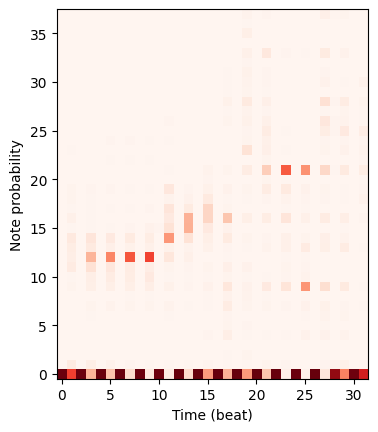

In [49]:
# Generate initial music sequence before training with RL
rl_net.generate_music_sequence(visualize_probs=True, title='pre_q', length=32)

In [50]:
rl_net.train(num_steps=1500000, exploration_period=500000)

INFO:tensorflow:Evaluating initial model...
INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/q-0.npz
INFO:tensorflow:0
INFO:tensorflow:/tmp/rl_tuner/q-0.meta
INFO:tensorflow:500
INFO:tensorflow:/tmp/rl_tuner/q-0.data-00000-of-00001
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/q-0.index
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/q.ckpt-50000.index
INFO:tensorflow:0
INFO:tensorflow:/tmp/rl_tuner/q.ckpt-50000.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/q.ckpt-50000.meta
INFO:tensorflow:1700
INFO:tensorflow:Training iteration 50000
INFO:tensorflow:	Reward for last 50000 steps: -177673.9712887144
INFO:tensorflow:		Music theory reward: -26948.988581215315
INFO:tensorflow:		Note RNN reward: -150724.98270750046
Training iteration 50000
	Reward for last 50000 steps: -177673.9712887144
		Music theory reward: -26948.988581215315
		Note RNN reward: -150724.98270750046
INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/q-50000

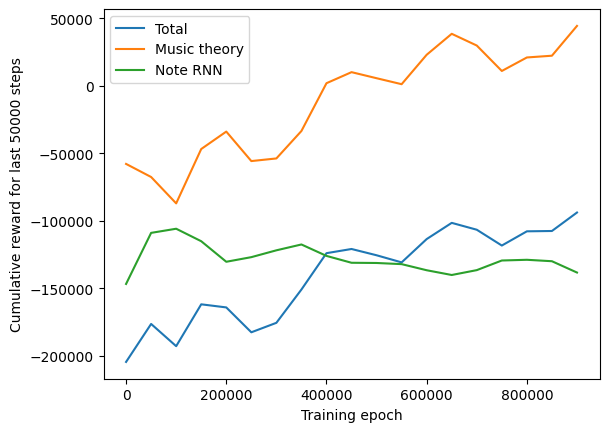

In [34]:
rl_net.plot_rewards()

INFO:tensorflow:Priming with note 8
INFO:tensorflow:Generated sequence: [0, 0, 37, 37, 0, 14, 0, 0, 1, 21, 14, 1, 18, 1, 16, 1, 18, 18, 14, 18, 14, 21, 1, 18, 1, 14, 14, 19, 1, 19, 1, 16]
Generated sequence: [0, 0, 37, 37, 0, 14, 0, 0, 1, 21, 14, 1, 18, 1, 16, 1, 18, 18, 14, 18, 14, 21, 1, 18, 1, 14, 14, 19, 1, 19, 1, 16]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


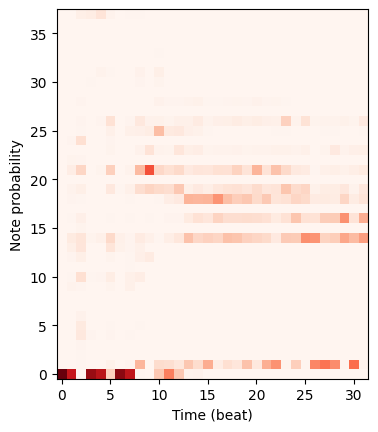

In [51]:
rl_net.generate_music_sequence(visualize_probs=True, title='post_q', length=32)

In [ ]:
# If you're happy with the model, save a version!
rl_net.save_model(output_dir, 'my_cool_model')

In [20]:
# Compute statistics about how well the model adheres to the music theory rules.
stat_dict = rl_net.evaluate_music_theory_metrics(num_compositions=100)

INFO:tensorflow:Total compositions: 100.0
Total notes:3200.0
	Compositions starting with tonic: 0.0
	Compositions with unique highest note:64.0
	Compositions with unique lowest note:60.0
	Number of resolved leaps:23.0
	Number of double leaps:15.0
	Notes not in key:78.0
	Notes in motif:1974.0
	Notes in repeated motif:0.0
	Notes excessively repeated:9.0

	Percent compositions starting with tonic:0.0
	Percent compositions with unique highest note:0.64
	Percent compositions with unique lowest note:0.6
	Percent of leaps resolved:0.6052631578947368
	Percent notes not in key:0.024375
	Percent notes in motif:0.616875
	Percent notes in repeated motif:0.0
	Percent notes excessively repeated:0.0028125

	Average autocorrelation of lag1:-0.3582471037466425
	Average autocorrelation of lag2:0.11628916860566242
	Average autocorrelation of lag3:0.042299296575698045

	Avg. num octave jumps per composition:0.4
	Avg. num sevenths per composition:0.03
	Avg. num fifths per composition:0.58
	Avg. num sixths 

In [ ]:
dqn_hparams.set_hparam("random_action_probability", 0.15)


0.15


In [24]:
rl_net.train(num_steps=500000, exploration_period=500000)

INFO:tensorflow:Evaluating initial model...


/home/vinkovskiy/magenta/magenta/magenta/models/rl_tuner/rl_tuner_ops.py:138: RuntimeWarning: invalid value encountered in double_scalars
  return (x[lag:] * x[:n - lag]).sum() / float(n) / c0


INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/psi-1450000.meta
INFO:tensorflow:500
INFO:tensorflow:/tmp/rl_tuner/psi-1450000.data-00000-of-00001
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/psi-1450000.index
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-1500000.meta
INFO:tensorflow:500
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-1500000.index
INFO:tensorflow:500
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-1500000.data-00000-of-00001
INFO:tensorflow:1700
INFO:tensorflow:Training iteration 50000
INFO:tensorflow:	Reward for last 50000 steps: -185745.9598260589
INFO:tensorflow:		Music theory reward: 32808.96010225352
INFO:tensorflow:		Note RNN reward: -218554.9199283123
Training iteration 50000
	Reward for last 50000 steps: -185745.9598260589
		Music theory reward: 32808.96010225352
		Note RNN reward: -218554.9199283123
INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/psi-1500000.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl

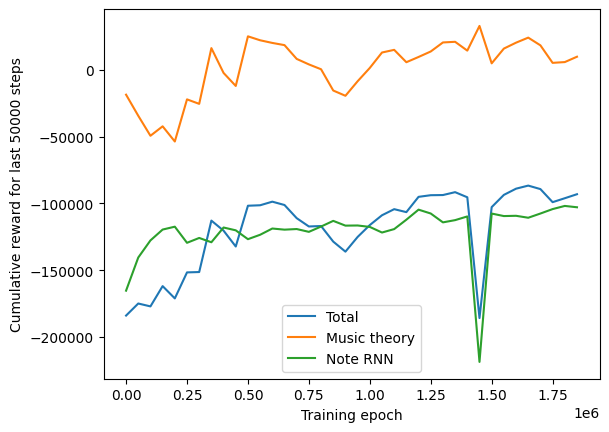

In [25]:
rl_net.plot_rewards()

INFO:tensorflow:Priming with note 25
INFO:tensorflow:Generated sequence: [0, 0, 26, 31, 0, 0, 19, 0, 0, 19, 18, 0, 0, 23, 0, 0, 26, 0, 23, 25, 0, 19, 0, 19, 0, 19, 18, 0, 21, 0, 0, 21, 0, 0, 23, 0, 0, 19, 0, 23, 0, 21, 0, 19, 0, 21, 0, 23, 0, 19, 0, 21, 19, 0, 19, 0, 0, 23, 0, 21, 26, 0, 21, 0, 19, 0, 23, 0, 25, 0, 21, 0, 21, 0, 19, 18, 0, 0, 19, 0, 19, 0, 21, 0, 23, 0, 21, 0, 0, 19, 0, 16, 0, 0, 23, 0, 0, 19, 0, 0, 23, 0, 23, 0, 0, 0, 0, 26, 0, 0, 23, 25, 0, 0, 21, 0, 21, 0, 25, 0, 19, 0, 19, 0, 0, 23, 0, 25]
Generated sequence: [0, 0, 26, 31, 0, 0, 19, 0, 0, 19, 18, 0, 0, 23, 0, 0, 26, 0, 23, 25, 0, 19, 0, 19, 0, 19, 18, 0, 21, 0, 0, 21, 0, 0, 23, 0, 0, 19, 0, 23, 0, 21, 0, 19, 0, 21, 0, 23, 0, 19, 0, 21, 19, 0, 19, 0, 0, 23, 0, 21, 26, 0, 21, 0, 19, 0, 23, 0, 25, 0, 21, 0, 21, 0, 19, 18, 0, 0, 19, 0, 19, 0, 21, 0, 23, 0, 21, 0, 0, 19, 0, 16, 0, 0, 23, 0, 0, 19, 0, 0, 23, 0, 23, 0, 0, 0, 0, 26, 0, 0, 23, 25, 0, 0, 21, 0, 21, 0, 25, 0, 19, 0, 19, 0, 0, 23, 0, 25]
INFO:tensorflow:Wrote

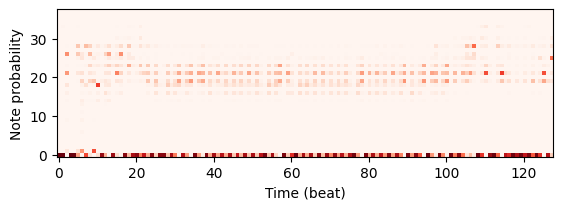

In [26]:
rl_net.generate_music_sequence(visualize_probs=True, title='post_rl', length=128)

## Test 2

In [111]:
output_dir = "/tmp/rl_tuner/"
note_rnn_checkpoint_dir = '/home/vinkovskiy/magenta/magenta/note_rnn_checkpoints'
note_rnn_checkpoint_name = 'note_rnn.ckpt'
note_rnn_type = 'default'
training_steps = 1000000
exploration_steps = 500000
exploration_mode = 'boltzmann'
output_every_nth = 50000
num_notes_in_melody = 32
reward_scaler = 1
midi_primer = '/home/vinkovskiy/magenta/magenta/magenta/testdata/primer.mid'
algorithm = 'psi'
output_ckpt = algorithm + ".ckpt"
backup_checkpoint_file = os.path.join(note_rnn_checkpoint_dir, note_rnn_checkpoint_name)

In [112]:
dqn_hparams = contrib_training.HParams(
      random_action_probability=0.15,
      store_every_nth=1,
      train_every_nth=5,
      minibatch_size=32,
      discount_rate=0.5,
      max_experience=100000,
      target_network_update_rate=0.01)

In [113]:
rl_net_psi_2 = rl_tuner.RLTuner(output_dir=output_dir,
                          midi_primer=midi_primer,
                          dqn_hparams=dqn_hparams,
                          reward_scaler=reward_scaler,
                          save_name=output_ckpt,
                          output_every_nth=output_every_nth,
                          note_rnn_checkpoint_dir=note_rnn_checkpoint_dir,
                          note_rnn_checkpoint_file=backup_checkpoint_file,
                          note_rnn_type=note_rnn_type,
                          note_rnn_hparams=hparams,
                          num_notes_in_melody=num_notes_in_melody,
                          exploration_mode=exploration_mode,
                          algorithm=algorithm)

INFO:tensorflow:Initializing q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope q_network
INFO:tensorflow:Initializing target q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope target_q_network
INFO:tensorflow:Initializing reward network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope reward_rnn


/home/vinkovskiy/magenta/magenta/magenta/models/rl_tuner/rl_tuner_ops.py:310: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.LSTMCell(num_units, state_is_tuple=state_is_tuple)


INFO:tensorflow:Q network cell: <keras.layers.rnn.legacy_cells.MultiRNNCell object at 0x7f2f5d565e90>
INFO:tensorflow:Adding RL graph variables
INFO:tensorflow:Adding reward computation portion of the graph
INFO:tensorflow:Adding taking action portion of graph
INFO:tensorflow:Add estimating future rewards portion of graph
INFO:tensorflow:Adding q value prediction portion of graph
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0 is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel_0 instead.
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0/gradients is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel_0/gradients instead.
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0 is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/bias_0 instead.
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0/gradients is illegal;

INFO:tensorflow:Priming with note 2
INFO:tensorflow:Generated sequence: [0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 14, 0, 26, 0, 14, 0, 26, 0, 14, 0, 0, 0, 26, 0, 14, 0, 14, 0, 26, 0, 14]
Generated sequence: [0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 14, 0, 26, 0, 14, 0, 26, 0, 14, 0, 0, 0, 26, 0, 14, 0, 14, 0, 26, 0, 14]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


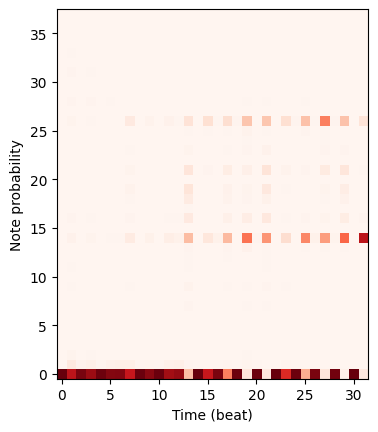

In [124]:
# Generate initial music sequence before training with RL
rl_net_psi_2.generate_music_sequence(visualize_probs=True, title='pre_rl', length=32)

In [125]:
rl_net_psi_2.train(num_steps=1000000, exploration_period=500000)

INFO:tensorflow:Evaluating initial model...


/home/vinkovskiy/magenta/magenta/magenta/models/rl_tuner/rl_tuner_ops.py:138: RuntimeWarning: invalid value encountered in double_scalars
  return (x[lag:] * x[:n - lag]).sum() / float(n) / c0


INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/psi-0.npz
INFO:tensorflow:0
INFO:tensorflow:/tmp/rl_tuner/psi-0.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi-0.meta
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/psi-0.index
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.index
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/psi.ckpt-50000.meta
INFO:tensorflow:1700
INFO:tensorflow:Training iteration 50000
INFO:tensorflow:	Reward for last 50000 steps: -252690.03880418986
INFO:tensorflow:		Music theory reward: -122217.34324444986
INFO:tensorflow:		Note RNN reward: -130472.69555974007
Training iteration 50000
	Reward for last 50000 steps: -252690.03880418986
		Music theory reward: -122217.34324444986
		Note RNN reward: -130472.69555974007
INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/psi-50000.meta
INFO:tensorflow:

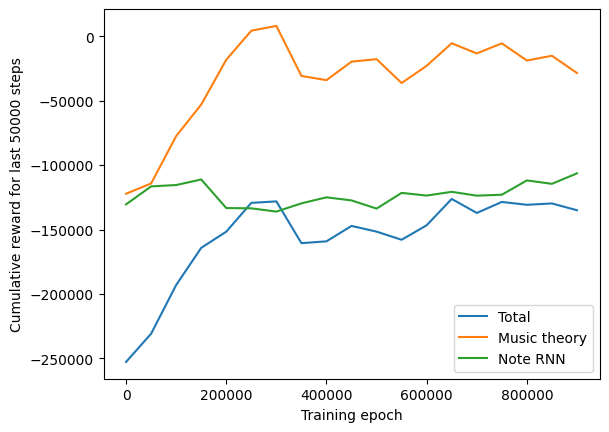

In [126]:
rl_net_psi_2.plot_rewards()

INFO:tensorflow:Priming with note 15
INFO:tensorflow:Generated sequence: [12, 0, 12, 36, 17, 3, 18, 20, 19, 2, 19, 2, 25, 20, 2, 19, 27, 22, 20, 26, 20, 23, 23, 20, 17, 19, 35, 24, 19, 3, 15, 3]
Generated sequence: [12, 0, 12, 36, 17, 3, 18, 20, 19, 2, 19, 2, 25, 20, 2, 19, 27, 22, 20, 26, 20, 23, 23, 20, 17, 19, 35, 24, 19, 3, 15, 3]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


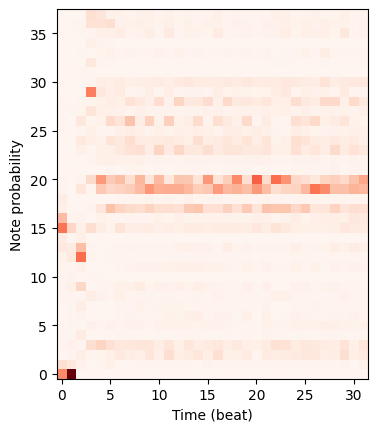

In [127]:
rl_net.generate_music_sequence(visualize_probs=True, most_probable=False)

# Test 3

In [7]:
output_dir = "/tmp/rl_tuner/"
note_rnn_checkpoint_dir = '/home/vinkovskiy/magenta/magenta/note_rnn_checkpoints'
note_rnn_checkpoint_name = 'note_rnn.ckpt'
note_rnn_type = 'default'
training_steps = 1000000
exploration_steps = 500000
exploration_mode = 'boltzmann'
output_every_nth = 50000
num_notes_in_melody = 32
reward_scaler = 1
midi_primer = '/home/vinkovskiy/magenta/magenta/primer.mid'
algorithm = 'q'
output_ckpt = algorithm + ".ckpt"
backup_checkpoint_file = os.path.join(note_rnn_checkpoint_dir, note_rnn_checkpoint_name)

In [8]:
dqn_hparams = contrib_training.HParams(
      random_action_probability=0.1,
      store_every_nth=1,
      train_every_nth=5,
      minibatch_size=32,
      discount_rate=0.5,
      max_experience=100000,
      target_network_update_rate=0.01)

In [9]:
rl_net_q_1 = rl_tuner.RLTuner(output_dir=output_dir,
                          midi_primer=midi_primer,
                          dqn_hparams=dqn_hparams,
                          reward_scaler=reward_scaler,
                          save_name=output_ckpt,
                          output_every_nth=output_every_nth,
                          note_rnn_checkpoint_dir=note_rnn_checkpoint_dir,
                          note_rnn_checkpoint_file=backup_checkpoint_file,
                          note_rnn_type=note_rnn_type,
                          note_rnn_hparams=hparams,
                          num_notes_in_melody=num_notes_in_melody,
                          exploration_mode=exploration_mode,
                          algorithm=algorithm)

INFO:tensorflow:Initializing q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope q_network
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Initializing target q network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope target_q_network


/home/vinkovskiy/magenta/magenta/magenta/models/rl_tuner/rl_tuner_ops.py:310: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.LSTMCell(num_units, state_is_tuple=state_is_tuple)


INFO:tensorflow:Initializing reward network
INFO:tensorflow:Using custom hparams
INFO:tensorflow:Initializing melody RNN graph for scope reward_rnn
INFO:tensorflow:Q network cell: <keras.layers.rnn.legacy_cells.MultiRNNCell object at 0x7d6df070f710>
INFO:tensorflow:Adding RL graph variables
INFO:tensorflow:Adding reward computation portion of the graph
INFO:tensorflow:Adding taking action portion of graph
Instructions for updating:
Use the `axis` argument instead
INFO:tensorflow:Add estimating future rewards portion of graph
INFO:tensorflow:Adding q value prediction portion of graph
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0 is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel_0 instead.
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0/gradients is illegal; using q_network/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel_0/gradients instead.
INFO:tensorflow:Summary name q_network/rnn/multi_rnn_cell/

2024-12-04 06:49:22.092844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-12-04 06:49:22.092879: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-12-04 06:49:22.092904: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Ubuntu-VM): /proc/driver/nvidia/version does not exist
2024-12-04 06:49:22.093117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 06:49:22.110056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization 


Successfully initialized internal nets from checkpoint!
INFO:tensorflow:
Successfully initialized internal nets from checkpoint!


INFO:tensorflow:Priming with note 22
INFO:tensorflow:Generated sequence: [0, 23, 0, 18, 0, 0, 0, 20, 0, 21, 0, 0, 0, 22, 0, 22, 0, 21, 0, 19, 0, 0, 0, 19, 0, 0, 0, 21, 0, 21, 0, 0]
Generated sequence: [0, 23, 0, 18, 0, 0, 0, 20, 0, 21, 0, 0, 0, 22, 0, 22, 0, 21, 0, 19, 0, 0, 0, 19, 0, 0, 0, 21, 0, 21, 0, 0]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


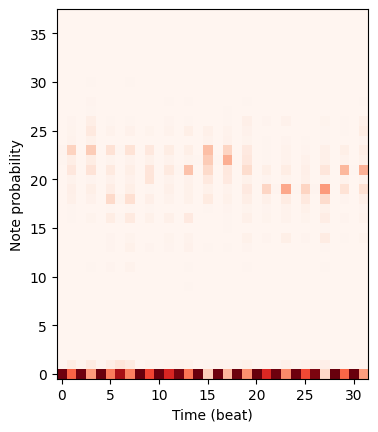

In [13]:
# Generate initial music sequence before training with RL
rl_net_q_1.generate_music_sequence(visualize_probs=True, title='pre_rl', length=32)

In [14]:
rl_net_q_1.train(num_steps=1000000, exploration_period=500000)

INFO:tensorflow:Evaluating initial model...


/home/vinkovskiy/magenta/magenta/magenta/models/rl_tuner/rl_tuner_ops.py:138: RuntimeWarning: invalid value encountered in double_scalars
  return (x[lag:] * x[:n - lag]).sum() / float(n) / c0


INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/q-0.npz
INFO:tensorflow:0
INFO:tensorflow:/tmp/rl_tuner/q-0.meta
INFO:tensorflow:500
INFO:tensorflow:/tmp/rl_tuner/q-0.data-00000-of-00001
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/q-0.index
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/q.ckpt-50000.index
INFO:tensorflow:0
INFO:tensorflow:/tmp/rl_tuner/q.ckpt-50000.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/q.ckpt-50000.meta
INFO:tensorflow:1700
INFO:tensorflow:Training iteration 50000
INFO:tensorflow:	Reward for last 50000 steps: -201246.8012977147
INFO:tensorflow:		Music theory reward: -54598.471437863765
INFO:tensorflow:		Note RNN reward: -146648.3298598528
Training iteration 50000
	Reward for last 50000 steps: -201246.8012977147
		Music theory reward: -54598.471437863765
		Note RNN reward: -146648.3298598528
INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/q-500000.npz
INFO:tensorflow:0
INFO:tensorflow:/tmp/r

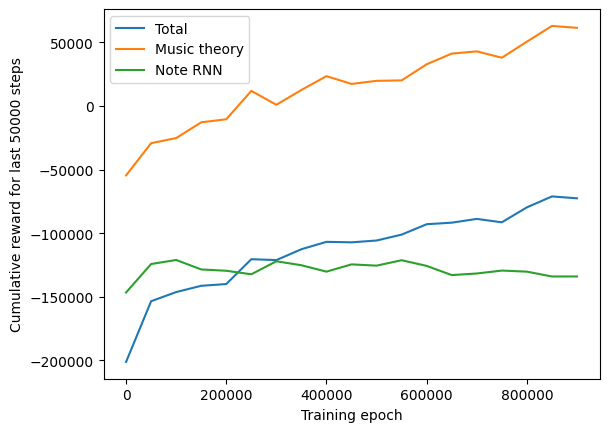

In [15]:
rl_net_q_1.plot_rewards()

INFO:tensorflow:Priming with note 9
INFO:tensorflow:Generated sequence: [0, 0, 1, 11, 0, 0, 16, 18, 0, 0, 21, 0, 23, 0, 21, 0, 1, 21, 0, 23, 0, 25, 0, 23, 0, 21, 26, 0, 23, 1, 23, 1]
Generated sequence: [0, 0, 1, 11, 0, 0, 16, 18, 0, 0, 21, 0, 23, 0, 21, 0, 1, 21, 0, 23, 0, 25, 0, 23, 0, 21, 26, 0, 23, 1, 23, 1]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


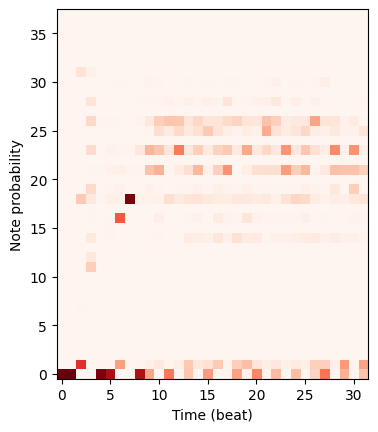

In [22]:
rl_net_q_1.generate_music_sequence(visualize_probs=True, length=32, most_probable=True)

In [24]:
rl_net_q_1.save_model(output_dir, 'q_1')

INFO:tensorflow:/tmp/rl_tuner/-950000.meta
INFO:tensorflow:500
INFO:tensorflow:/tmp/rl_tuner/-950000.data-00000-of-00001
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/-950000.index
INFO:tensorflow:1700


In [25]:
stat_dict = rl_net_q_1.evaluate_music_theory_metrics(num_compositions=100)

INFO:tensorflow:Total compositions: 100.0
Total notes:3200.0
	Compositions starting with tonic: 0.0
	Compositions with unique highest note:67.0
	Compositions with unique lowest note:61.0
	Number of resolved leaps:44.0
	Number of double leaps:24.0
	Notes not in key:7.0
	Notes in motif:2123.0
	Notes in repeated motif:0.0
	Notes excessively repeated:0.0

	Percent compositions starting with tonic:0.0
	Percent compositions with unique highest note:0.67
	Percent compositions with unique lowest note:0.61
	Percent of leaps resolved:0.6470588235294118
	Percent notes not in key:0.0021875
	Percent notes in motif:0.6634375
	Percent notes in repeated motif:0.0
	Percent notes excessively repeated:0.0

	Average autocorrelation of lag1:-0.184892046975961
	Average autocorrelation of lag2:0.17487037506042621
	Average autocorrelation of lag3:-0.014366076244651225

	Avg. num octave jumps per composition:0.13
	Avg. num sevenths per composition:0.06
	Avg. num fifths per composition:0.81
	Avg. num sixths per

In [26]:
rl_net_q_1.train(num_steps=2000000, exploration_period=500000)

INFO:tensorflow:Evaluating initial model...


/home/vinkovskiy/magenta/magenta/magenta/models/rl_tuner/rl_tuner_ops.py:138: RuntimeWarning: invalid value encountered in double_scalars
  return (x[lag:] * x[:n - lag]).sum() / float(n) / c0


INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/q-950000.index
INFO:tensorflow:0
INFO:tensorflow:/tmp/rl_tuner/q-950000.data-00000-of-00001
INFO:tensorflow:1200
INFO:tensorflow:/tmp/rl_tuner/q-950000.meta
INFO:tensorflow:1700
INFO:tensorflow:/tmp/rl_tuner/q.ckpt-1000000.meta
INFO:tensorflow:500
INFO:tensorflow:/tmp/rl_tuner/q.ckpt-1000000.index
INFO:tensorflow:500
INFO:tensorflow:/tmp/rl_tuner/q.ckpt-1000000.data-00000-of-00001
INFO:tensorflow:1700
INFO:tensorflow:Training iteration 50000
INFO:tensorflow:	Reward for last 50000 steps: -151579.3694147817
INFO:tensorflow:		Music theory reward: 116326.9010721718
INFO:tensorflow:		Note RNN reward: -267906.2704869509
Training iteration 50000
	Reward for last 50000 steps: -151579.3694147817
		Music theory reward: 116326.9010721718
		Note RNN reward: -267906.2704869509
INFO:tensorflow:Evaluating model...
INFO:tensorflow:/tmp/rl_tuner/q-1000000.meta
INFO:tensorflow:500
INFO:tensorflow:/tmp/rl_tuner/q-1000000.index
INFO:tensorf

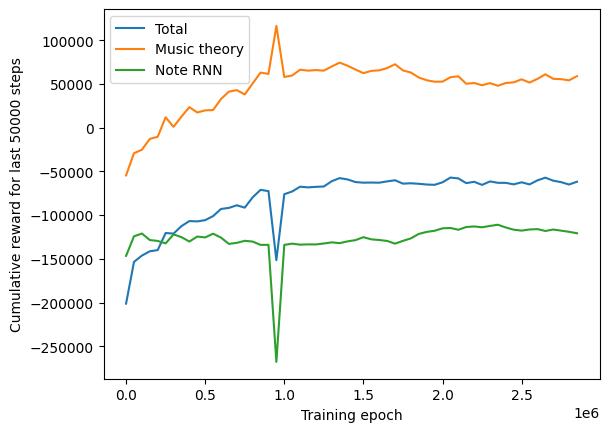

In [27]:
rl_net_q_1.plot_rewards()

INFO:tensorflow:Priming with note 13
INFO:tensorflow:Generated sequence: [25, 0, 0, 1, 18, 0, 21, 0, 19, 0, 25, 21, 0, 28, 0, 21, 0, 0, 28, 25, 1, 26, 0, 0, 23, 25, 0, 21, 0, 0, 1, 23]
Generated sequence: [25, 0, 0, 1, 18, 0, 21, 0, 19, 0, 25, 21, 0, 28, 0, 21, 0, 0, 28, 25, 1, 26, 0, 0, 23, 25, 0, 21, 0, 0, 1, 23]
INFO:tensorflow:Wrote a melody to /tmp/rl_tuner/
INFO:tensorflow:Visualizing note selection probabilities:


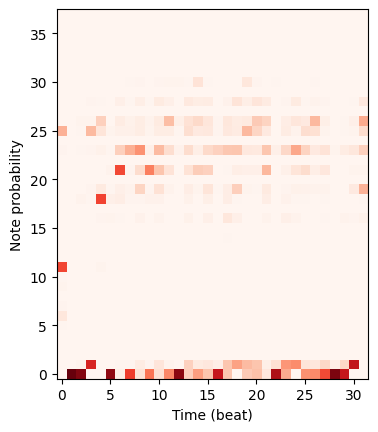

In [35]:
rl_net_q_1.generate_music_sequence(visualize_probs=True, length=32, most_probable=False)